In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
pwd

'/Users/sebas/projects/metabolomics'

In [39]:
import os 
os.chdir('/Users/sebas/projects/metabolomics/')
# Set the environment variable
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [40]:
import dill
import torch
from torch.utils.data import DataLoader
import lightning.pytorch as pl

from pytorch_lightning.callbacks import ProgressBar
from src.train_utils import TrainUtils
import matplotlib.pyplot as plt
from src.config import Config
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
import os
from src.parser import Parser
import random
from src.weight_sampling import WeightSampling
from src.losscallback import LossCallback
from src.molecular_pairs_set import MolecularPairsSet
from src.sanity_checks import SanityChecks
from src.transformers.postprocessing import Postprocessing
from scipy.stats import spearmanr
import seaborn as sns
from src.ordinal_classification.load_data_ordinal import LoadDataOrdinal
from src.ordinal_classification.embedder_ordinal import EmbedderOrdinal
from sklearn.metrics import confusion_matrix


In [41]:
## Replicate standard regression training DONE


In [42]:
## Discretize the range

In [43]:
## Train a classification model

In [44]:
## Use gumbel softmax function

In [45]:
config = Config()

In [46]:
config.USE_GUMBEL=True

In [47]:
config.N_CLASSES=6

In [48]:
config.D_MODEL=128

In [49]:
config.bins_uniformise_INFERENCE=config.N_CLASSES-1

In [50]:
config.use_uniform_data_INFERENCE = True

## Replicate standard regression training

In [51]:
data_folder= '/Users/sebas/projects/data/'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'

In [52]:
config.dataset_path=dataset_path
config.CHECKPOINT_DIR = data_folder + 'temp_training/'

In [53]:
# parameters
dataset_path = config.dataset_path
epochs = config.epochs
bins_uniformise_inference = config.bins_uniformise_INFERENCE
enable_progress_bar = config.enable_progress_bar
fig_path = config.CHECKPOINT_DIR + f"scatter_plot_{config.MODEL_CODE}.png"
model_code = config.MODEL_CODE

In [54]:
print("loading file")
# Load the dataset from the pickle file
with open(dataset_path, "rb") as file:
    dataset = dill.load(file)

molecule_pairs_train = dataset["molecule_pairs_train"]
molecule_pairs_val = dataset["molecule_pairs_val"]
molecule_pairs_test = dataset["molecule_pairs_test"]
uniformed_molecule_pairs_test = dataset["uniformed_molecule_pairs_test"]

loading file


In [55]:

print(f"Number of pairs for train: {len(molecule_pairs_train)}")
print(f"Number of pairs for val: {len(molecule_pairs_val)}")
print(f"Number of pairs for test: {len(molecule_pairs_test)}")
print(f"Number of pairs for uniform test: {len(uniformed_molecule_pairs_test)}")

Number of pairs for train: 955957
Number of pairs for val: 586692
Number of pairs for test: 586781
Number of pairs for uniform test: 40940


In [56]:
## CALCULATION OF WEIGHTS
train_binned_list, _ = TrainUtils.divide_data_into_bins(
    molecule_pairs_train,
    config.N_CLASSES-1,
    bin_sim_1=True, 
)
#train_binned_list, _ = TrainUtils.divide_data_into_bins(
#    molecule_pairs_train,
#    config.N_CLASSES-1,
#    bin_sim_1=False, 
#)


In [57]:
[t.indexes_tani.shape for t in train_binned_list]

[(299985, 3), (166229, 3), (316846, 3), (115705, 3), (25305, 3), (31887, 3)]

In [58]:
weights, range_weights = WeightSampling.compute_weights_categories(train_binned_list)
#weights, range_weights = WeightSampling.compute_weights(train_binned_list)

In [59]:
weights

array([0.03622318, 0.06537013, 0.03429556, 0.0939148 , 0.42941758,
       0.34077874])

In [60]:
range_weights

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [61]:
weights_tr = WeightSampling.compute_sample_weights_categories(molecule_pairs_train, weights)
weights_val = WeightSampling.compute_sample_weights_categories(molecule_pairs_val, weights)
#weights_tr = WeightSampling.compute_sample_weights(molecule_pairs_train, weights)
#weights_val = WeightSampling.compute_sample_weights(molecule_pairs_val, weights)

In [62]:
dataset_train = LoadDataOrdinal.from_molecule_pairs_to_dataset(molecule_pairs_train, training=True)
# dataset_test = LoadData.from_molecule_pairs_to_dataset(m_test)
dataset_val = LoadDataOrdinal.from_molecule_pairs_to_dataset(molecule_pairs_val)

Preprocessing all the data ...



0it [00:00, ?it/s]
2887it [00:00, 28869.13it/s]
5924it [00:00, 29744.78it/s]
8899it [00:00, 15479.91it/s]
11550it [00:00, 18270.14it/s]
13847it [00:00, 19491.67it/s]
18591it [00:00, 27172.95it/s]
23029it [00:00, 32023.58it/s]
27750it [00:01, 36383.85it/s]
32418it [00:01, 39378.16it/s]
37442it [00:01, 42565.38it/s]
42383it [00:01, 44586.71it/s]
47411it [00:01, 46275.09it/s]
52641it [00:01, 48068.68it/s]
57855it [00:01, 49282.59it/s]
63014it [00:01, 49970.43it/s]
68045it [00:01, 50020.56it/s]
73071it [00:01, 49697.39it/s]
78058it [00:02, 49712.67it/s]
83042it [00:02, 49373.04it/s]
87989it [00:02, 48975.76it/s]
92948it [00:02, 49155.96it/s]
97929it [00:02, 49348.84it/s]
103040it [00:02, 49871.54it/s]
108053it [00:02, 49948.26it/s]
113050it [00:02, 49951.03it/s]
118047it [00:02, 49741.00it/s]
123023it [00:02, 49484.70it/s]
127973it [00:03, 48953.84it/s]
133020it [00:03, 49401.13it/s]
138140it [00:03, 49935.06it/s]
143352it [00:03, 50584.69it/s]
148582it [00:03, 51093.39it/s]
153734it [00:

Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...



0it [00:00, ?it/s]
2043it [00:00, 20426.76it/s]
6908it [00:00, 37023.86it/s]
11860it [00:00, 42726.39it/s]
16888it [00:00, 45706.22it/s]
22006it [00:00, 47678.22it/s]
31318it [00:00, 45847.15it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [63]:
# delete variables that are not useful for memory savings
del molecule_pairs_train
del molecule_pairs_val
del molecule_pairs_test
del uniformed_molecule_pairs_test

In [64]:
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """WeightedRandomSampler except allows for more than 2^24 samples to be sampled"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(
            range(0, len(self.weights)),
            size=self.num_samples,
            p=self.weights.numpy() / torch.sum(self.weights).numpy(),
            replace=self.replacement,
        )
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())


train_sampler = CustomWeightedRandomSampler(
    weights=weights_tr, num_samples=len(dataset_train), replacement=True
)
val_sampler = CustomWeightedRandomSampler(
    weights=weights_val, num_samples=len(dataset_val), replacement=True
)

In [65]:
print("Creating train data loader")
dataloader_train = DataLoader(
    dataset_train, batch_size=config.BATCH_SIZE, sampler=train_sampler, num_workers=10
)

Creating train data loader


In [66]:
def worker_init_fn(
    worker_id,
):  # ensure the dataloader for validation is the same for every epoch
    seed = 42
    torch.manual_seed(seed)
    # Set the same seed for reproducibility in NumPy and Python's random module
    np.random.seed(seed)
    random.seed(seed)


print("Creating val data loader")
dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    sampler=val_sampler,
    worker_init_fn=worker_init_fn,
    num_workers=0,
)


Creating val data loader


In [67]:
# Define the ModelCheckpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model",
    monitor="validation_loss_epoch",
    mode="min",
    save_top_k=1,
)

checkpoint_n_steps_callback = pl.callbacks.ModelCheckpoint(
    dirpath=config.CHECKPOINT_DIR,
    filename="best_model_n_steps",
    every_n_train_steps=1000,
    save_last=True,
    save_top_k=1,
)


# checkpoint_callback = SaveBestModelCallback(file_path=config.best_model_path)
progress_bar_callback = ProgressBar()

# loss callback
losscallback = LossCallback(file_path=config.CHECKPOINT_DIR + f"loss.png")
print("define model")


define model


In [68]:
config.USE_GUMBEL

True

In [69]:
model = EmbedderOrdinal(
    d_model=int(config.D_MODEL),
    n_layers=int(config.N_LAYERS),
    n_classes=config.N_CLASSES,
    weights=None,
    lr=config.LR,
    use_cosine_distance=config.use_cosine_distance,
    use_gumbel = config.USE_GUMBEL,
)

Using cosine library from Pytorch?: True


In [70]:
trainer = pl.Trainer(
    max_steps=1000,
    #max_epochs=1,
    callbacks=[checkpoint_callback, checkpoint_n_steps_callback, losscallback],
    enable_progress_bar=enable_progress_bar,
    # val_check_interval= config.validate_after_ratio,
)
# trainer = pl.Trainer(max_steps=100,  callbacks=[checkpoint_callback, losscallback], enable_progress_bar=enable_progress_bar)
trainer.fit(
    model=model,
    train_dataloaders=(dataloader_train),
    val_dataloaders=dataloader_val,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/sebas/projects/data/temp_training exists and is not empty.

   | Name                    | Type                             | Params
------------------------------------------------------------------------------
0  | linear                  | Linear                           | 16.5 K
1  | linear_regression       | Linear                           | 129   
2  | fixed_linear_regression | FixedLinearRegression            | 129   
3  | relu                    | ReLU                             | 0     
4  | spectrum_encoder        | SpectrumTransformerEncoderCustom | 1.7 M 
5  | regression_loss         | MSELoss                          | 0     
6  | dropout                 | Dropout         

Sanity Checking: |                                                                                            …

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = 

Train loss:
[]
Validation loss
[4.768124580383301]


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                                                   …

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:369: `ModelCheckpoint(monitor='validation_loss_epoch')` could not find the monitored key in the returned metrics: ['train_loss', 'train_loss_step', 'train_loss_epoch', 'epoch', 'step']. HINT: Did you call `log('validation_loss_epoch', value)` in the `LightningModule`?
`Trainer.fit` stopped: `max_steps=1000` reached.
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10eb040e0>
Traceback (most recent call last):
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/sebas/miniconda3/envs/transformers/lib/python3.11/multiprocessing/p

Error in callback <function flush_figures at 0x2ec2d4220> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



## Inference

In [92]:
#best_model_path = model_path = data_folder + 'best_model_exhaustive_sampled_128n_20240618.ckpt'
#best_model_path = config.CHECKPOINT_DIR + f"best_model_n_steps-v9.ckpt"
best_model_path = config.CHECKPOINT_DIR + f"last-v9.ckpt"

In [93]:
molecule_pairs_test = dataset["molecule_pairs_test"]
print(f"Number of molecule pairs: {len(molecule_pairs_test)}")
print("Uniformize the data")
uniformed_molecule_pairs_test, _ = TrainUtils.uniformise(
    molecule_pairs_test,
    number_bins=bins_uniformise_inference,
    return_binned_list=True,
    bin_sim_1=True,
    #bin_sim_1=False,
)  # do not treat sim==1 as another bin

Number of molecule pairs: 586781
Uniformize the data


In [94]:
# dataset_train = LoadData.from_molecule_pairs_to_dataset(m_train)
dataset_test = LoadDataOrdinal.from_molecule_pairs_to_dataset(uniformed_molecule_pairs_test)
dataloader_test = DataLoader(dataset_test, batch_size=config.BATCH_SIZE, shuffle=False)

Preprocessing all the data ...



0it [00:00, ?it/s]
2083it [00:00, 20828.13it/s]
6982it [00:00, 37391.62it/s]
11917it [00:00, 42850.07it/s]
16879it [00:00, 45520.45it/s]
21955it [00:00, 47409.24it/s]
26810it [00:00, 47793.49it/s]
33719it [00:00, 45683.52it/s]


Finished preprocessing 
loading data
Normalizing intensities
Creating dictionaries


In [95]:
# Testinbest_model = Embedder.load_from_checkpoint(checkpoint_callback.best_model_path, d_model=64, n_layers=2)
trainer = pl.Trainer(max_epochs=2, enable_progress_bar=enable_progress_bar)
best_model = EmbedderOrdinal.load_from_checkpoint(
    best_model_path,
    d_model=int(config.D_MODEL),
    n_layers=int(config.N_LAYERS),
    n_classes=config.N_CLASSES,
    use_gumbel=config.USE_GUMBEL,
    use_element_wise=True,
    use_cosine_distance=config.use_cosine_distance,
    
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using cosine library from Pytorch?: True


## Postprocessing

In [96]:
pred_test = trainer.predict(
    best_model,
    dataloader_test,
)
similarities_test = Postprocessing.get_similarities(dataloader_test)


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_precursor = torch.tensor(kwargs["precursor_mass"].float())
/Users/sebas/projects/metabolomics/src/transformers/spectrum_transformer_encoder_custom.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  charge_precursor = torch.tensor(kwargs["precursor_charge"].float())


In [97]:
print(pred_test[0][4])
print(similarities_test[127])

tensor([0., 0., 1., 0., 0., 0.])
0.0


In [98]:
pred_test[0][6]

tensor([0., 0., 1., 0., 0., 0.])

In [99]:
np.argwhere(pred_test[0][0]>0.1)[0]

tensor([0])

In [100]:
np.argwhere(pred_test[0][0]>0.9)[0].numel()

1

In [101]:
def which_index(p, threshold=0.999):
    result= np.argwhere(p>threshold)[0]
     #
    if result.numel()==0:
        #return np.argmax(p)
        return np.nan
    else:
        return result[-1]
    #return np.argmax(p)

In [102]:
# flat the results
flat_pred_test = []
for pred in pred_test:
    flat_pred_test = flat_pred_test + [which_index(p) for p in pred]
flat_pred_test=np.array( flat_pred_test)

In [103]:
#list(pred_test)

In [104]:
flat_pred_test[0]

0

## Corr. Analysis

In [105]:
similarities_test=np.array(similarities_test)
flat_pred_test=np.array(flat_pred_test)

In [106]:
len(similarities_test)

16002

In [107]:
similarities_test_cleaned= similarities_test[~np.isnan(flat_pred_test)]
flat_pred_test_cleaned= flat_pred_test[~np.isnan(flat_pred_test)]

In [108]:
len(similarities_test_cleaned)

16002

In [109]:

corr_model, p_value_model= spearmanr(similarities_test_cleaned, flat_pred_test_cleaned)


In [110]:
corr_model

0.262459625962496

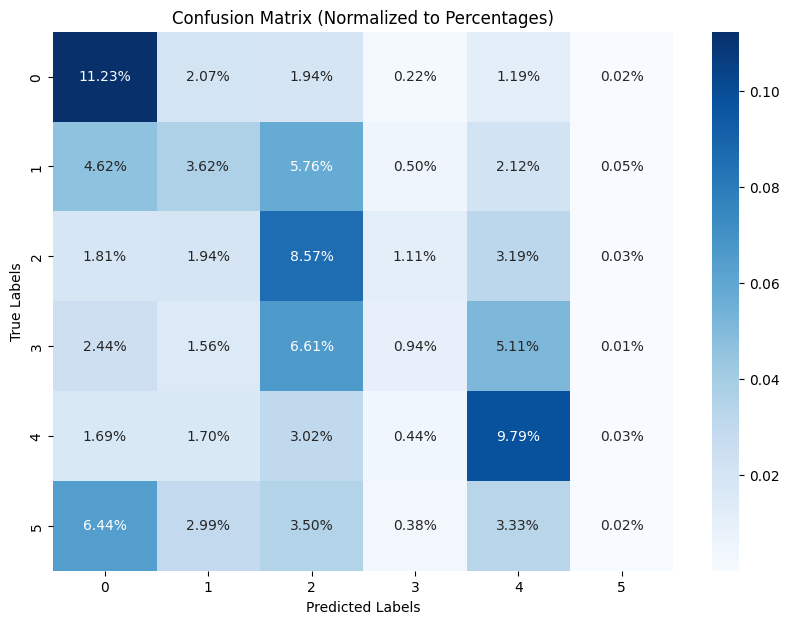

In [111]:
# Compute the confusion matrix
cm = confusion_matrix(similarities_test_cleaned, flat_pred_test_cleaned)
# Normalize the confusion matrix by the number of true instances for each class
cm_normalized = cm.astype('float') / cm.sum()
# Plot the confusion matrix with percentages
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized to Percentages)')
plt.show()

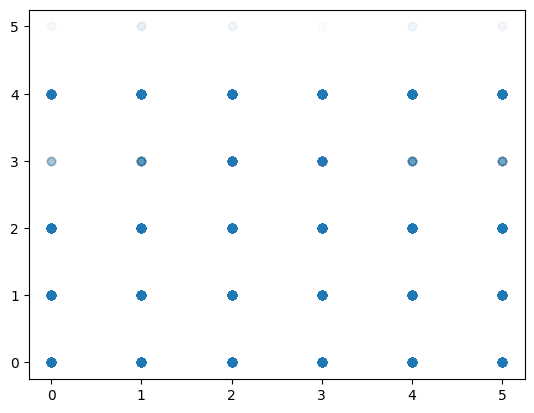

In [112]:
plt.scatter(similarities_test, flat_pred_test, alpha=0.01)

##### 